In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
import reg_helper as RHelper
import pandas as pd

Using TensorFlow backend.


In [2]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials, STATUS_OK, STATUS_FAIL
import hyperopt

In [59]:
folder = 'data/'
X = np.load(folder+'X_all.npy')
y = np.load(folder+'y_all.npy').reshape(-1)

In [66]:
X = (X - np.mean(X, axis=0))/np.std(X, axis=0)

In [67]:
# Split entre train y val
X_train = X[:len(X)//2]
y_train = y[:len(y)//2]
X_val = X[len(X)//2:]
y_val = y[len(y)//2:]

In [68]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping

In [94]:
es = EarlyStopping(monitor='val_acc', verbose=1, patience=6, mode='max', restore_best_weights=True)
model = Sequential()
model.add(Dense(100, input_shape=(2,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(Adam(lr=0.1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=len(X_train), epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks=[es])

Train on 59 samples, validate on 59 samples
Epoch 1/100
59/59 [==============================] - 5s 83ms/step - loss: 0.6937 - acc: 0.4915 - val_loss: 0.7789 - val_acc: 0.5424
Epoch 2/100
59/59 [==============================] - 0s 87us/step - loss: 0.6894 - acc: 0.5424 - val_loss: 0.6460 - val_acc: 0.6271
Epoch 3/100
59/59 [==============================] - 0s 61us/step - loss: 0.6162 - acc: 0.6780 - val_loss: 0.6513 - val_acc: 0.6441
Epoch 4/100
59/59 [==============================] - 0s 64us/step - loss: 0.6026 - acc: 0.7119 - val_loss: 0.6408 - val_acc: 0.6102
Epoch 5/100
59/59 [==============================] - 0s 58us/step - loss: 0.5611 - acc: 0.6949 - val_loss: 0.6160 - val_acc: 0.6102
Epoch 6/100
59/59 [==============================] - 0s 65us/step - loss: 0.5420 - acc: 0.7458 - val_loss: 0.6003 - val_acc: 0.6441
Epoch 7/100
59/59 [==============================] - 0s 62us/step - loss: 0.5238 - acc: 0.7458 - val_loss: 0.5690 - val_acc: 0.6949
Epoch 8/100
59/59 [=============

In [114]:
def objective(params):
    model = Sequential()
    model.add(Dense(params['hidden_units'], input_shape=(2,), activation=params['activation']))
    model.add(Dense(1, activation='sigmoid'))
    es = EarlyStopping(monitor='val_acc', verbose=1, patience=6, mode='max', restore_best_weights=True)
    if params['optimizer']=='adam':
        optimizer = Adam(lr=params['learning_rate'])
    else:
        optimizer = SGD(lr=params['learning_rate'])
    model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=len(X_train), epochs=100, verbose=0, validation_data=(X_val, y_val), callbacks=[es])
    acc = np.array(model.evaluate(X_val, y_val, verbose=0)[1])
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [115]:
space = {
    'learning_rate': hp.loguniform('learning_rate', -3, -1),
    'hidden_units': hp.choice('hidden_units', np.arange(5, 200)),
    'optimizer': hp.choice('optimizer', ['adam']),
    'activation': hp.choice('activation', ['relu'])
}

tpe_trials = Trials()

best = fmin(fn=objective,
            space=space,
            trials = tpe_trials,
            verbose=1,
            algo=hyperopt.tpe.suggest,
            # algo=hyperopt.rand.suggest,
            return_argmin=False,
            max_evals=200)

Restoring model weights from the end of the best epoch
Epoch 00016: early stopping
Restoring model weights from the end of the best epoch
Epoch 00017: early stopping
Restoring model weights from the end of the best epoch
Epoch 00019: early stopping
Restoring model weights from the end of the best epoch
Epoch 00017: early stopping
Restoring model weights from the end of the best epoch
Epoch 00025: early stopping
Restoring model weights from the end of the best epoch
Epoch 00017: early stopping
Restoring model weights from the end of the best epoch
Epoch 00020: early stopping
Restoring model weights from the end of the best epoch
Epoch 00027: early stopping
Restoring model weights from the end of the best epoch
Epoch 00017: early stopping
Restoring model weights from the end of the best epoch
Epoch 00018: early stopping
Restoring model weights from the end of the best epoch
Epoch 00021: early stopping
Restoring model weights from the end of the best epoch
Epoch 00018: early stopping
Rest

In [116]:
best

{'activation': 'relu',
 'hidden_units': 164,
 'learning_rate': 0.21603425540067883,
 'optimizer': 'adam'}

In [117]:
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 
                            'iteration': tpe_trials.idxs_vals[0]['hidden_units'],
                            'hidden_units': np.arange(5, 200)[tpe_trials.idxs_vals[1]['hidden_units']]})
tpe_results.set_index('iteration')
tpe_results.loc[tpe_trials.idxs_vals[0]['activation'], 'activation']  = np.array(['sigmoid', 'relu'])[tpe_trials.idxs_vals[1]['activation']]
tpe_results.loc[tpe_trials.idxs_vals[0]['optimizer'], 'optimizer']  = np.array(['adam', 'sgd'])[tpe_trials.idxs_vals[1]['optimizer']]
tpe_results.loc[tpe_trials.idxs_vals[0]['learning_rate'], 'learning_rate']  = tpe_trials.idxs_vals[1]['learning_rate']

In [118]:
tpe_results.sort_values('loss')

,loss,iteration,hidden_units,activation,optimizer,learning_rate
96,-0.881356,96,164,sigmoid,adam,0.216034
83,-0.881356,83,45,sigmoid,adam,0.279301
114,-0.864407,114,178,sigmoid,adam,0.168038
112,-0.864407,112,123,sigmoid,adam,0.164654
67,-0.864407,67,50,sigmoid,adam,0.265381
63,-0.864407,63,149,sigmoid,adam,0.251402
169,-0.864407,169,139,sigmoid,adam,0.278875
167,-0.864407,167,114,sigmoid,adam,0.232662
25,-0.864407,25,112,sigmoid,adam,0.096204
0,-0.864407,0,164,sigmoid,adam,0.055371


Text(0.5, 1.0, 'lr vs iterations')

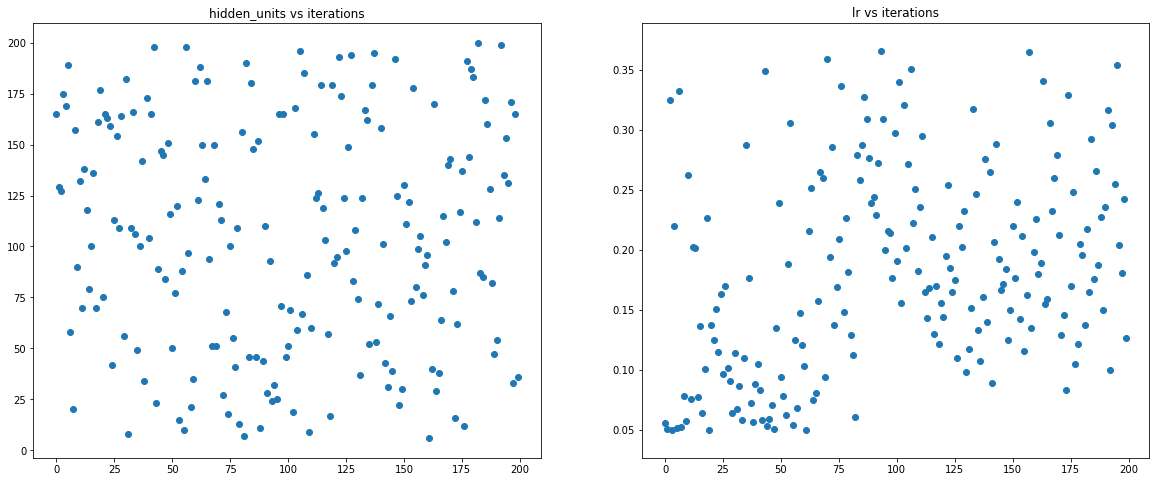

In [127]:
f, ax = plt.subplots(1, 2, figsize=(20,8))
ax = ax.reshape(-1)
# ax[0].scatter(tpe_results['iteration'], tpe_results['activation']+1)
# ax[0].set_title('activation vs iterations')
# ax[1].scatter(tpe_results['iteration'], tpe_results['optimizer'])
# ax[1].set_title('optimizer vs iterations')
ax[0].scatter(tpe_results['iteration'], tpe_results['hidden_units']+1)
ax[0].set_title('hidden_units vs iterations')
ax[1].scatter(tpe_results['iteration'], tpe_results['learning_rate'])
ax[1].set_title('lr vs iterations')

In [121]:
best

{'activation': 'relu',
 'hidden_units': 164,
 'learning_rate': 0.21603425540067883,
 'optimizer': 'adam'}

In [122]:
best_idx = tpe_results.sort_values('loss')['iteration'].values[0]

In [123]:
tpe_trials.results[best_idx]['model'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_598 (Dense)            (None, 164)               492       
_________________________________________________________________
dense_599 (Dense)            (None, 1)                 165       
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


59/59 [==============================] - 0s 141us/step


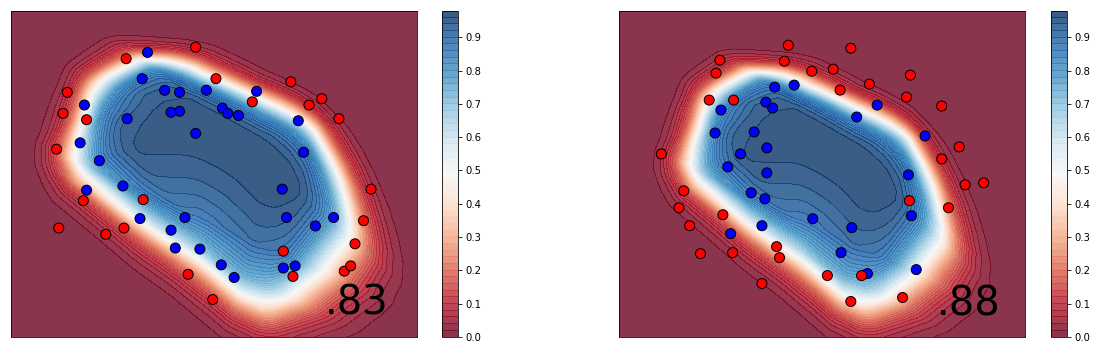

In [124]:
clf = tpe_trials.results[best_idx]['model']

score_train = clf.evaluate(X_train, y_train)[1]
score_test = clf.evaluate(X_val, y_val)[1]
# Graficamos probabilidades en el plano de la combinación de todos los clasificadores
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
RHelper.plot_boundaries_keras(X_train, y_train, score_train, clf.predict, ax=ax1)
RHelper.plot_boundaries_keras(X_val, y_val, score_test, clf.predict, ax=ax2)

In [125]:
clf.save('model_88.hdf5')